In [25]:

from abc import ABCMeta, abstractmethod
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import six

# 每个人平均寿命期望是75年，约75*365=27375天
K_INIT_LIVING_DAYS = 27375

class Person(object):
    """
        人类
    """

    def __init__(self):
        # 初始化人平均能活的寿命
        self.living = K_INIT_LIVING_DAYS
        # 初始化幸福指数
        self.happiness = 0
        # 初始化财富值
        self.wealth = 0
        # 初始化名望权利
        self.fame = 0
        # 活着的第几天
        self.living_day = 0

    def live_one_day(self, seek):
        """
        每天只能进行一个seek，这个seek决定了你今天追求的是什么，得到了什么
        seek的类型属于下面将编写的BaseSeekDay
        :param seek:
        :return:
        """
        # 调用每个独特的BaseSeekDay类都会实现的do_seek_day，得到今天的收获
        consume_living, happiness, wealth, fame = seek.do_seek_day()
        # 每天要减去生命消耗，有些seek前面还会增加生命
        self.living -= consume_living
        # seek得到的幸福指数积累
        self.happiness += happiness
        # seek得到的财富积累
        self.wealth += wealth
        # seek得到的名望权力积累
        self.fame += fame
        # 活完这一天了
        self.living_day += 1
    

In [4]:
class BaseSeekDay(six.with_metaclass(ABCMeta, object)):
    def __init__(self):
        # 每个追求每天消耗生命的常数
        self.living_consume = 0

        # 每个追求每天幸福指数常数
        self.happiness_base = 0

        # 每个追求每天财富积累常数
        self.wealth_base = 0
        # 每个追求每天名望权利积累常数
        self.fame_base = 0

        # 每个追求每天消耗生命的可变因素序列
        self.living_factor = [0]

        # 每个追求每天幸福指数的可变因素序列
        self.happiness_factor = [0]

        # 每个追求每天财富积累的可变因素序列
        self.wealth_factor = [0]
        # 每个追求每天名望权利的可变因素序列
        self.fame_factor = [0]

        # 追求了多少天了这一生
        self.do_seek_day_cnt = 0
        # 子类进行常数及可变因素序列设置
        self._init_self()

    @abstractmethod
    def _init_self(self, *args, **kwargs):
        # 子类必须实现，设置自己的生命消耗的常数，幸福指数常数等常数设置
        pass

    @abstractmethod
    def _gen_living_days(self, *args, **kwargs):
        # 子类必须实现，设置自己的可变因素序列
        pass

    def do_seek_day(self):
        """
        每一天的追求具体seek
        :return:
        """
        # 生命消耗=living_consume:消耗常数 * happiness_factor:可变序列
        if self.do_seek_day_cnt >= len(self.living_factor):
            # 超出len(self.living_factor), 就取最后一个living_factor[-1]
            consume_living = \
                self.living_factor[-1] * self.living_consume
        else:
            # 每个类自定义这个追求的消耗生命常数，以及living_factor，比如
            # HealthSeekDay追求健康，living_factor序列的值即由负值->正值
            # 每个子类living_factor会有自己特点的变化速度及序列长度，导致每个
            # 追求对生命的消耗随着追求的次数变化不一
            consume_living = self.living_factor[self.do_seek_day_cnt] \
                             * self.living_consume
        # 幸福指数=happiness_base:幸福常数 * happiness_factor:可变序列
        if self.do_seek_day_cnt >= len(self.happiness_factor):
            # 超出len(self.happiness_factor), 就取最后一个
            # 由于happiness_factor值由:n—>0 所以happiness_factor[-1]=0
            # 即随着追求一个事物的次数过多后会变的没有幸福感
            happiness = self.happiness_factor[
                            -1] * self.happiness_base
        else:
            # 每个类自定义这个追求的幸福指数常数，以及happiness_factor
            # happiness_factor子类的定义一般是从高－>低变化
            happiness = self.happiness_factor[
                            self.do_seek_day_cnt] * self.happiness_base
        # 财富积累=wealth_base:积累常数 * wealth_factor:可变序列
        if self.do_seek_day_cnt >= len(self.wealth_factor):
            # 超出len(self.wealth_factor), 就取最后一个
            wealth = self.wealth_factor[-1] * self.wealth_base
        else:
            # 每个类自定义这个追求的财富指数常数，以及wealth_factor
            wealth = self.wealth_factor[
                         self.do_seek_day_cnt] * self.wealth_base
        # 权利积累=fame_base:积累常数 * fame_factor:可变序列
        if self.do_seek_day_cnt >= len(self.fame_factor):
            # 超出len(self.fame_factor), 就取最后一个
            fame = self.fame_factor[-1] * self.fame_base
        else:
            # 每个类自定义这个追求的名望权利指数常数，以及fame_factor
            fame = self.fame_factor[
                       self.do_seek_day_cnt] * self.fame_base
        # 追求了多少天了这一生 + 1
        self.do_seek_day_cnt += 1
        # 返回这个追求这一天对生命的消耗，得到的幸福，财富，名望权利
        return consume_living, happiness, wealth, fame


In [5]:
def regular_mm(group):
    # 最小-最大规范化
    return (group - group.min()) / (group.max() - group.min())


class HealthSeekDay(BaseSeekDay):
    """
        HealthSeekDay追求健康长寿的一天:
        形象：健身，旅游，娱乐，做感兴趣的事情。
        抽象：追求健康长寿。
    """

    def _init_self(self):
        # 每天对生命消耗的常数＝1，即代表1天
        self.living_consume = 1
        # 每天幸福指数常数＝1
        self.happiness_base = 1
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成12000个序列，因为下面的happiness_factor序列值由1－>0
        # 所以大于12000次的追求都将只是单纯消耗生命，并不增加幸福指数
        # 即随着做一件事情的次数越来越多，幸福感越来越低，直到完全体会不到幸福
        days = np.arange(1, 12000)
        # 基础函数选用sqrt, 影响序列变化速度
        living_days = np.sqrt(days)

        """
            对生命消耗可变因素序列值由-1->1, 也就是这个追求一开始的时候对生命
            的消耗为负增长，延长了生命，随着追求的次数不断增多对生命的消耗转为正
            数因为即使一个人天天锻炼身体，天天吃营养品，也还是会有自然死亡的那
            一天
        """
        # *2-1的目的:regular_mm在0-1之间,HealthSeekDay要结果在－1，1之间
        self.living_factor = regular_mm(living_days) * 2 - 1
        # 结果在1-0之间 [::-1]: 将0->1转换到1->0
        self.happiness_factor = regular_mm(days)[::-1]

In [6]:
# 初始化我, 你一生的故事：HealthSeekDay
me = Person()
# 初始化追求健康长寿快乐
seek_health = HealthSeekDay()
while me.living > 0:
    # 只要还活着，就追求健康长寿快乐
    me.live_one_day(seek_health)

print('只追求健康长寿快乐活了{}年，幸福指数{},积累财富{},名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       me.wealth, me.fame))

只追求健康长寿快乐活了97.12年，幸福指数5999.5,积累财富0,名望权力0


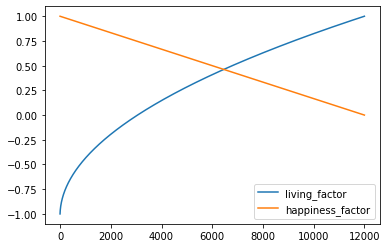

In [7]:
plt.plot(seek_health.living_factor * seek_health.living_consume)
plt.plot(seek_health.happiness_factor * seek_health.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')

In [8]:
class StockSeekDay(BaseSeekDay):
    """
        StockSeekDay追求财富金钱的一天:
        形象：做股票投资赚钱的事情。
        抽象：追求财富金钱
    """

    def _init_self(self, show=False):
        # 每天对生命消耗的常数＝2，即代表2天
        self.living_consume = 2
        # 每天幸福指数常数＝0.5
        self.happiness_base = 0.5
        # 财富积累常数＝10，默认＝0
        self.wealth_base = 10
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成10000个序列
        days = np.arange(1, 10000)
        # 针对生命消耗living_factor的基础函数还是sqrt
        living_days = np.sqrt(days)
        # 由于不需要像HealthSeekDay从负数开始，所以直接regular_mm 即:0->1
        self.living_factor = regular_mm(living_days)
        
        # 针对幸福感可变序列使用了np.power4，即变化速度比sqrt快
        happiness_days = np.power(days, 4)
        # 幸福指数可变因素会快速递减由1->0
        self.happiness_factor = regular_mm(happiness_days)[::-1]
        
        """
            这里简单设定wealth_factor=living_factor
            living_factor(0-1), 导致wealth_factor(0-1), 即财富积累越到
            后面越有效率，速度越快，头一个100万最难赚
        """
        self.wealth_factor = self.living_factor

In [9]:
# 初始化我, 你一生的故事：StockSeekDay
me = Person()
# 初始化追求财富金钱
seek_stock = StockSeekDay()
while me.living > 0:
    # 只要还活着，就追求财富金钱
    me.live_one_day(seek_stock)

print('只追求财富金钱活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       round(me.wealth, 2), me.fame))

只追求财富金钱活了46.72年，幸福指数1000.15, 积累财富136878.35, 名望权力0


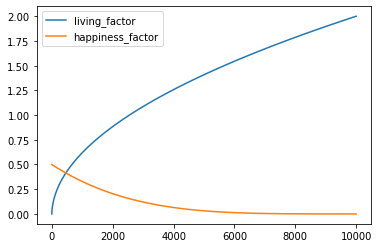

In [10]:
plt.plot(seek_stock.living_factor * seek_stock.living_consume)
plt.plot(seek_stock.happiness_factor * seek_stock.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best')

In [11]:
class FameSeekDay(BaseSeekDay):
    """
        FameTask追求名望权力的一天:
        追求名望权力
    """

    def _init_self(self):
        # 每天对生命消耗的常数＝3，即代表3天
        self.living_consume = 3
        # 每天幸福指数常数＝0.6
        self.happiness_base = 0.6
        # 名望权利积累常数＝10，默认＝0
        self.fame_base = 10
        # 设定可变因素序列
        self._gen_living_days()

    def _gen_living_days(self):
        # 只生成12000个序列
        days = np.arange(1, 12000)
        # 针对生命消耗living_factor的基础函数还是sqrt
        living_days = np.sqrt(days)
        # 由于不需要像HealthSeekDay从负数开始，所以直接regular_mm 即:0->1
        self.living_factor = regular_mm(living_days)

        # 针对幸福感可变序列使用了np.power2
        # 即变化速度比StockSeekDay慢但比HealthSeekDay快
        happiness_days = np.power(days, 2)
        # 幸福指数可变因素递减由1->0
        self.happiness_factor = regular_mm(happiness_days)[::-1]

        # 这里简单设定fame_factor=living_factor
        self.fame_factor = self.living_factor

In [12]:
# 初始化我, 你一生的故事：FameSeekDay
me = Person()
# 初始化追求名望权力
seek_fame = FameSeekDay()
while me.living > 0:
    # 只要还活着，就追求名望权力
    me.live_one_day(seek_fame)

print('只追求名望权力活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
      (round(me.living_day / 365, 2), round(me.happiness, 2),
       round(me.wealth, 2), round(me.fame, 2)))

只追求名望权力活了36.06年，幸福指数2400.1, 积累财富0, 名望权力91259.86


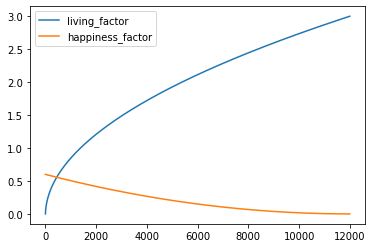

In [13]:

plt.plot(seek_fame.living_factor * seek_fame.living_consume)
plt.plot(seek_fame.happiness_factor * seek_fame.happiness_base)
plt.legend(['living_factor', 'happiness_factor'], loc='best');

In [18]:
def my_life(weights):
    """
        追求健康长寿快乐的权重:weights[0]
        追求财富金钱的权重:weights[1]
        追求名望权力的权重:weights[2]
    """
    # 追求健康长寿快乐
    seek_health = HealthSeekDay()
    # 追求财富金钱
    seek_stock = StockSeekDay()
    # 追求名望权力
    seek_fame = FameSeekDay()

    # 放在一个list中对对应下面np.random.choice中的index[0, 1, 2]
    seek_list = [seek_health, seek_stock, seek_fame]

    # 初始化我
    me = Person()
    # 加权随机抽取序列。80000天肯定够了, 80000天快220年了。。。
    seek_choice = np.random.choice([0, 1, 2], 80000, p=weights)

    while me.living > 0:
        # 追求从加权随机抽取序列已经初始化好的
        seek_ind = seek_choice[me.living_day]
        seek = seek_list[seek_ind]
        # 只要还活着，就追求
        me.live_one_day(seek)
    return round(me.living_day / 365, 2), round(me.happiness, 2), \
        round(me.wealth, 2), round(me.fame, 2)

In [19]:
living_day, happiness, wealth, fame = my_life([0.4, 0.3, 0.3])
print('活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format(
    living_day, happiness, wealth, fame))

活了77.05年，幸福指数9318.95, 积累财富50490.03, 名望权力46508.54


In [20]:
weights = np.random.random(3)
weights /= np.sum(weights)
weights

array([0.0939, 0.6136, 0.2925])

In [22]:
from abupy import AbuProgress
progress = AbuProgress(2000, 0, label='my_life...')
    
result = []
for _ in range(2000):
    # 2000次随机权重分配
    weights = np.random.random(3)
    weights /= np.sum(weights)
    # result中：tuple[0]权重weights,，tuple[1]my_life返回的结果
    result.append((weights, my_life(weights)))
    progress.show()

FloatProgress(value=0.0)

In [23]:
# result中tuple[1]=my_life返回的结果, my_life[1]=幸福指数，so->x[1][1]
sorted_scores = sorted(result, key=lambda x: x[1][1], reverse=True)
# 将最优权重sorted_scores[0][0]代入my_life得到结果
living_day, happiness, wealth, fame = my_life(sorted_scores[0][0])

print('活了{}年，幸福指数{}, 积累财富{}, 名望权力{}'.format
          (living_day, happiness, wealth, fame))

print('人生最优权重：追求健康{:.3f},追求财富{:.3f},追求名望{:.3f}'.format(
        sorted_scores[0][0][0], sorted_scores[0][0][1],
        sorted_scores[0][0][2]))

活了75.32年，幸福指数9369.8, 积累财富31269.57, 名望权力58500.07
人生最优权重：追求健康0.428,追求财富0.221,追求名望0.352


(2104.4889999999996, 4800.833]    200
(4800.833, 6234.74]               200
(6234.74, 7154.061]               200
(7154.061, 7745.098]              200
(7745.098, 8208.375]              200
(8208.375, 8585.946]              200
(8585.946, 8847.416]              200
(8847.416, 9073.756]              200
(9073.756, 9252.736]              200
(9252.736, 9372.69]               200
dtype: int64


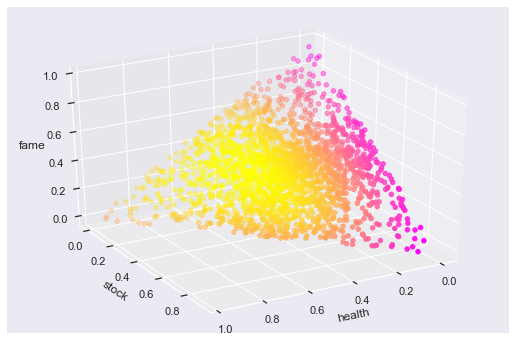

In [26]:
from mpl_toolkits.mplot3d import Axes3D
"""
    result中: tuple[0]权重weights, tuple[1]my_life返回的结果
    r[0][0]: 追求健康长寿快乐的权重
    r[0][1]: 追求财富金钱的权重
    r[0][2]: 追求名望权力的权重
    r[1][1]: my_life[1]=幸福指数
"""
result_show = np.array(
    [[r[0][0], r[0][1], r[0][2], r[1][1]] for r in result])

fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
ax.view_init(30, 60)
"""
    x:追求健康长寿快乐的权重, y:追求财富金钱的权重
    z:追求名望权力的权重, c:color 幸福指数, 颜色越深越幸福
"""
ax.scatter3D(result_show[:, 0], result_show[:, 1], result_show[:, 2],
             c=result_show[:, 3], cmap='spring')
ax.set_xlabel('health')
ax.set_ylabel('stock')
ax.set_zlabel('fame')

# 幸福指数
happiness_result = result_show[:, 3]
# 使用qcut分10份
print(pd.qcut(happiness_result, 10).value_counts())